<table width="100%" style="border: none; border-collapse: collapse;">
  <tr>
    <td align="left" width="10%" style="border: none;">
      <img src="logocimat.png" width="120">
    </td>
    <td align="center" width="55%" style="border: none;">
      <h2>Centro de Investigación en Matemáticas, A.C.</h2>
    </td>
    <td align="right" width="25%" style="border: none;">
      <img src="logo_secihti.png" width="350">
    </td>
  </tr>
</table>

<p align="center">
  <img src="logo_insp.png" alt="Logo" width="250"/>
</p>

<h3 align="center">Clasificación automática de coberturas en imágenes aéreas mediante modelo Random Forest</h3>

<h4 align="center">Autor: Sarahi Ventura Angoa</h4>

<p align="center">Maestría en Cómputo Estadístico - CIMAT Mty</p>
<p align="center">Junio 2025</p>


<div class="alert alert-block alert-info">
Este <code>notebook</code> permite segmentar una imagen en superpíxeles, extraer características de cada superpíxel en forma paralela, y aplicar el modelo previamente entrenado para predecir la categoría de cada uno.

Como se mostró en los resultados del <code>notebook</code> <i>prueba_modelos_clasificacion_imagenes_aereas_rgb.ipynb</i>, el modelo con mejor desempeño fue <b>Random Forest</b>. Por ello, este será utilizado para clasificar automáticamente nuevas imágenes. Además, se extraen las <b>probabilidades por clase</b>, lo que permite estimar el nivel de confianza en cada predicción.

Como se ha mencionado, el modelo fue entrenado únicamente con coberturas de interés. Sin embargo, en imágenes urbanas aparecen elementos que no pertenecen a esas clases (vehículos, tinacos, postes, etc.), así como superpíxeles con mezcla de coberturas (ej. <i>hierba y pasto verde</i> con <i>suelo desnudo</i>, o <i>techo de lámina</i> con <i>árbol</i>). Por esta razón, se implementó una estrategia para asignar la categoría <b>“Sin etiqueta”</b> a superpíxeles cuya predicción no es clara.

<br>
<b> Estrategia para asignar la categoría "Sin etiqueta"</b><br><br>

Se analizaron las <b>probabilidades</b> asignadas por el modelo a cada clase. Para cada superpíxel, se obtuvieron las dos probabilidades más altas, y se calculó la <b>diferencia entre ellas</b>. Si esta diferencia es menor que un <b>umbral predefinido</b>, se considera que el modelo <i>no tiene suficiente certeza</i> y se asigna la categoría <b>“Sin etiqueta”</b>.

Este umbral se definió con base en un <i>análisis exploratorio</i> de la distribución de probabilidades de predicción, y no de forma arbitraria.
</div>



#
<div class="alert alert-block alert-success">
<b>Importacion de las librerias</b></div>


In [2]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                           I M P O R T S
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import cv2                      # Librería para procesamiento de imágenes (lectura, escritura, manipulación)
import os                       # Funciones para interactuar con el sistema de archivos (rutas, carpetas, etc.)
import pandas as pd             # Manipulación y análisis de datos tabulares (DataFrames)
import matplotlib.pyplot as plt # Visualización de gráficos básicos (líneas, barras, imágenes, etc.)
import seaborn as sns           # Visualización avanzada de datos estadísticos (mejor estilo que matplotlib)
import numpy as np              # Cálculo numérico, manejo de arrays y operaciones matemáticas vectorizadas
from sklearn.preprocessing import StandardScaler  # Estandarización de datos: media 0, varianza 1
import time                     # Para medir tiempos de ejecución (entrenamiento, predicción, etc.)
import joblib                   # Para guardar y cargar modelos entrenados en formato .pkl
import numpy as np              # Manipulación de los datos
# Verificación de carga exitosa
print("Todas las bibliotecas están funcionando correctamente!")


Todas las bibliotecas están funcionando correctamente!


## Índice

1. [Extraccion de caracteristicas](#conjunto-de-datos)  
2. [Predicciones](#preparacion-de-los-datos-para-el-entrenamiento)  

## Extraccion de caracteristicas



#
<div class="alert alert-block alert-success">
<b>Importación de las funciones auxiliares </b></div>




<div class="alert alert-block alert-info">
Para facilitar el proceso de predicción y visualización, se definieron funciones auxiliares en un archivo aparte llamado <i>funciones_auxiliares_predicciones.py</i>. Las funciones utilizadas para esta tarea, son las siguientes:<br><br>

<ul>
  <li><code>extrac_parallel_features</code>: Extraer las características de cada superpíxel utilizando procesamiento en paralelo.</li>
  <li><code>img_etiquetas_parallel</code>: Genera una imagen de salida donde cada superpíxel se pinta con un color específico según su categoría predicha.</li>
  <li><code>calcular_proporcion_pixeles</code>: Calcula el porcentaje de píxeles pertenecientes a cada categoría en una imagen, para conocer el porcentaje de cada cobertura.</li>
  <li><code>ver_superpixeles_categoria</code>: Permite visualizar solo los superpíxeles que pertenecen a una categoría específica, para  analizar la calidad de las predicciones por categoría.</li>
</ul>

Estas funciones mejoran la legibilidad del notebook y permiten reutilizar código en distintos análisis de imágenes.<br>

Para más detalles sobre su funcionamiento, se puede consultar el <code>notebook</code> <i>explicacion_funciones_auxiliares_predicciones.ipynb</i>.
</div>


In [3]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                   F U N C I O N E S   A U X I L I A R E S
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from funciones_auxiliares_predicciones import (
    extrac_parallel_features,       # Extrae las características de cada superpíxel en paralelo 
    img_etiquetas_parallel,         # Pinta la imagen con colores según la etiqueta de cada superpíxel
    calcular_proporcion_pixeles,    # Calcula el porcentaje de píxeles por categoría (para resumen por clase)
    ver_superpixeles_categoria      # Visualiza los superpíxeles pertenecientes a una categoría específica
)


#
<div class="alert alert-block alert-success">
<b> Uso de las funciones auxiliares para extraer las características de la imagén que se desean predecir sus categorias
</b></div>

Uso de las funciones auxiliares para extraer las características de la imagén que se desean predecir sus categorias

<div class="alert alert-block alert-info">
  <strong>ℹ️ Llamada de la función <code>extrac_parallel_features</code></strong><br>
  Esta función extrae las características de cada uno de los superíxeles, en paralelo para acelerar el proceso<br>
  Párametros de entrada:
  <ul>
    <li><code>path_image</code>: Ruta de la imagen a segmentar</li>
    <li><code>n_threads</code>: Número de hilos que se usarán para ejecutar la extracción en paralelo. </li>
    <li><code>rect</code>: Tipo de recorte para la matriz de textura GLCM. Puede ser <code>normal</code> u <code>orientado</code>.
    <li><code>std_data</code>: Si es <code>True</code>, se estandarizan los vectores de características (media 0, varianza 1)</li>
    <li><code>parametro_1</code>: Tamaño aproximado de cada superpíxel. Un valor mayor genera menos superpíxeles.</li>
    <li><code>parametro_2</code>: Compacidad (ruler). Valores más bajos ajustan mejor a los bordes.</li>
    <li><code>parametro_3</code>: Número de iteraciones del algoritmo SLIC. Más iteraciones aumentan la precisión.</li>
    <li><code>parametro_4</code>: Tamaño mínimo permitido para que una región se considere superpíxel.</li>
  </ul>

Como resultado, se genera un archivo .csv llamado Caract el cual contiene dichas características extraídas, que fueron utilizados en la clasificación automática de los superpíxeles.

<b>Salida:</b> Devuelve la segmentación, las etiquetas de superpíxeles, el número total de superpíxeles, el DataFrame con las características, el tiempo de extraccion de características y el tiempo de segmentación de la imagen.<br><br>

<b>📁 Archivo generado:</b><br>
Como resultado, se genera un archivo <code>.csv</code> con el prefijo <code>Caract_paralelo_</code> seguido del nombre de la imagen, que contiene las características extraídas para cada superpíxel de la imagen procesada.

</div>

In [4]:
# Ruta de la imagen a segmentar 
rut_image = "image_x5_331.jpg"

# parámetros de segmentacion
numero_hilos = 6  
tamano_superpixeles = 40   
ruler = 10                  
iteraciones = 10
tamano_minimo = 20 

#-------------------------------------------------------------------------------------
#  Llamada de la función para extraer características en paralelo
#-------------------------------------------------------------------------------------

img_seg_parallel, Labels_slic_parallel, number_slic_parallel, features_parallel, total_time_extrac_features_parallel, total_time_seg_slic = extrac_parallel_features(
    path_image=rut_image,
    rect='normal',
    n_threads=numero_hilos,    # numero de hilos
    parametro_1=tamano_superpixeles,
    parametro_2=ruler,
    parametro_3=iteraciones,
    parametro_4=tamano_minimo
)


<div class="alert alert-block alert-info">
  <strong> Dataframe que contiene las caracteristicas extraidas</strong><br>
</div>

In [5]:
features_parallel

,media_r,media_g,media_b,std_r,std_g,std_b,mean_gb,std_mg,density,dissimilarity_dist0_ang0,...,asm_dist2_ang3,asm_dist3_ang0,asm_dist3_ang1,asm_dist3_ang2,asm_dist3_ang3,asm_dist4_ang0,asm_dist4_ang1,asm_dist4_ang2,asm_dist4_ang3,indice
0,152.237156,146.836005,174.778463,47.341837,49.280618,38.036863,725.522400,756.095520,0.1632,11.351634,...,0.000342,0.000307,0.000303,0.000295,0.000366,0.000366,0.000317,0.000297,0.000301,0.0
1,232.307545,241.502558,249.658568,11.625086,12.239902,8.510099,243.722504,641.737732,0.0051,11.295344,...,0.001240,0.001122,0.001459,0.001108,0.001206,0.001206,0.001478,0.001134,0.001277,1.0
2,236.587449,247.118313,251.523663,6.485943,6.042493,4.487116,99.810699,60.387714,0.0005,5.679537,...,0.004500,0.004402,0.007721,0.004732,0.004283,0.004283,0.006766,0.004359,0.005833,2.0
3,237.130390,247.438398,251.671458,6.058446,5.993649,4.346972,107.132446,71.534088,0.0005,5.730392,...,0.004174,0.004184,0.006601,0.004239,0.004158,0.004158,0.006079,0.004236,0.005311,3.0
4,237.441353,247.051880,251.766165,6.758004,6.184958,4.363750,106.257141,65.208023,0.0004,5.517544,...,0.004639,0.004280,0.007331,0.004421,0.004511,0.004511,0.007100,0.004232,0.005833,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,112.909251,87.688106,85.736564,8.001633,9.016167,9.116004,185.719818,167.552872,0.0097,3.456468,...,0.003246,0.002697,0.002352,0.002123,0.003436,0.003436,0.002685,0.002559,0.002283,1099.0
1100,191.561377,204.610778,230.637725,6.087004,6.102027,6.090919,143.835327,107.969688,0.0060,6.095238,...,0.003786,0.003306,0.003634,0.003192,0.003082,0.003082,0.003320,0.002978,0.002888,1100.0
1101,79.991166,84.683746,55.070671,7.703993,5.495966,7.407519,165.846283,111.597954,0.0009,3.719680,...,0.003457,0.003008,0.002919,0.002925,0.003809,0.003809,0.002977,0.002738,0.002585,1101.0
1102,154.994039,138.281669,141.023845,12.496555,14.658038,16.022693,332.539490,233.620193,0.0224,4.899306,...,0.001467,0.001430,0.001390,0.001433,0.001583,0.001583,0.001376,0.001211,0.001296,1102.0


<div class="alert alert-block alert-info">
  <strong> Tiempos de ejecucion en paralelo:</strong><br>
</div>

In [6]:
print(f"Tiempo de extraccion de caracteristicas en paralelo", total_time_extrac_features_parallel)
print(f"Tiempo de segmentacion de la imagen", total_time_seg_slic)

Tiempo de extraccion de caracteristicas en paralelo 85.702
Tiempo de segmentacion de la imagen 1.3434


<div class="alert alert-block alert-info">
  <strong> Visualización de la segmentación</strong><br>
</div>


Número de superpixeles 1104


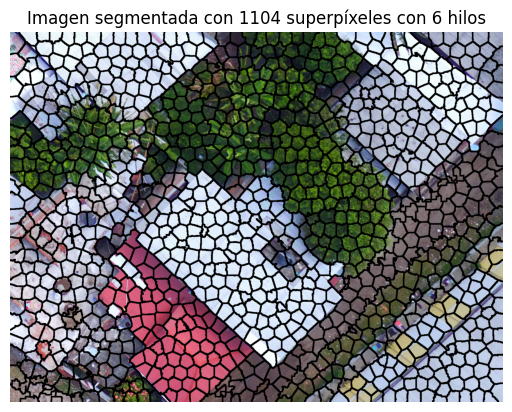

In [7]:
print(f"Número de superpixeles {number_slic_parallel}")
plt.imshow(img_seg_parallel)
plt.axis("off")
plt.title(f"Imagen segmentada con {number_slic_parallel} superpíxeles con {numero_hilos} hilos")
plt.show()

## Predicciones

<div class="alert alert-block alert-info">
  <strong>📦 Carga del modelo entrenado y columnas originales</strong><br><br>
  
  En esta sección se carga el modelo <i>Random Forest</i> previamente entrenado y almacenado en el archivo <code>modelo_random_forest_entrenado.pkl</code>. También se recupera el conjunto de columnas originales (<code>X_train</code>) utilizado durante su entrenamiento, el cual es necesario para garantizar que las predicciones sobre nuevas imágenes usen exactamente las mismas variables y en el mismo orden.<br><br>
  
  <b>Archivos cargados:</b>
  <ul>
    <li><code>modelo_random_forest_entrenado.pkl</code>: Contiene el pipeline entrenado con los mejores hiperparámetros.</li>
    <li><code>X_train.pkl</code>: Contiene los nombres y orden de las columnas utilizadas durante el entrenamiento.</li>
  </ul>
  
  Esto asegura que las características extraídas de nuevas imágenes sean compatibles con la estructura esperada por el modelo entrenado.
</div>


In [8]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CARGA DEL MODELO ENTRENADO Y VARIABLES DE ENTRADA
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Ruta al archivo del modelo entrenado
ruta_modelo = 'modelo_random_forest_entrenado.pkl'

# Ruta al .pkl con los nombres de columnas usadas en el entrenamiento
ruta_columnas_X_train = 'nombre_columnas_entrenamiento.pkl'

# Carga del modelo entrenado (pipeline completo)
pipe_rf = joblib.load(ruta_modelo)

# Carga de los nombres de columnas desde el CSV
X_train_names = joblib.load(ruta_columnas_X_train)


<div class="alert alert-block alert-info">
  <strong>🔍 Predicción de clases con el modelo entrenado</strong><br><br>

  Una vez extraídas las características de la imagen a clasificar, se seleccionan únicamente las columnas que fueron utilizadas durante el entrenamiento del modelo, para asegurar la consistencia de las variables.<br><br>

  Posteriormente, se realiza la predicción con el modelo <code>Random Forest</code> previamente entrenado:<br>
  <ul>
    <li>Se obtienen las <code>probabilidades</code> asignadas a cada clase para cada superpíxel mediante <code>predict_proba</code>.</li>
    <li>Se determina la clase con mayor probabilidad como la predicción final.</li>
    <li>Se agregan al <code>DataFrame</code> la columnas <code>prediction</code> (clase asignada)</li>
  </ul>

  Estas columnas permiten conocer no solo la categoría asignada a cada superpíxel, sino también el nivel de confianza del modelo en cada predicción.
</div>


In [9]:
# ---------------------------------------------
# Se seleccionan las mismas columnas utilizadas en el entrenamiento del modelo que las que se extrageron de la img a predecir
# ---------------------------------------------
covariables_img_predecir = features_parallel[X_train_names]

# ---------------------------------------------
# Prediccion de las probabilidades para cada clase
# ---------------------------------------------
probabilidades_image = pipe_rf.predict_proba(covariables_img_predecir)

# ---------------------------------------------
# Obtener la clase con mayor probabilidad como predicción final
# ---------------------------------------------
predicciones_image = np.argmax(probabilidades_image, axis=1)

# ---------------------------------------------
# Agregar la columna 'prediction'  al dataframe feature_parallel
# ---------------------------------------------
features_parallel["prediction"] = predicciones_image

<div class="alert alert-block alert-success">
  <strong>  Análisis exploratorio para la determinación del umbral</strong><br>
</div>

<div class="alert alert-block alert-info">
  <strong>📉 Identificación de incertidumbre en predicciones</strong><br><br>

  Como se mencionó anteriormente, también se extrajeron las probabilidades asociadas a cada clase. ¿Por qué? Porque, al segmentar la imagen, se generan superpíxeles que a veces contienen una mezcla de coberturas (por ejemplo, <i>techo de lámina</i> con <i>árbol</i>, o <i>hierba y pasto verde</i> con <i>suelo desnudo</i>), etc.<br><br>

  Además, las imágenes urbanas incluyen objetos y estructuras que no pertenecen a ninguna de las clases entrenadas, como automóviles, tinacos, postes, entre otras. Dado que el modelo fue entrenado solo con las clases de interés, <b>no tiene conocimiento</b> sobre estas otras categorías.<br><br>

  <b>🎯 Estrategia: categoría "Sin etiqueta"</b><br>
  Para detectar estos casos de ambigüedad o clases desconocidas, se implementó una estrategia basada en la <b>diferencia entre las dos probabilidades más altas</b> asignadas por el modelo. Si esa diferencia es pequeña, significa que el modelo <i>no tiene suficiente certeza para tomar una decisión clara</i>.<br><br>

  Se define un <b>umbral</b> (determinado previamente mediante análisis exploratorio), y si la diferencia entre la mayor y la segunda mayor probabilidad es menor a este valor, el superpíxel se asigna a la categoría <code>"Sin etiqueta"</code>.<br><br>

  <b>Columnas añadidas al DataFrame:</b>
  <ul>
    <li><code>max_proba</code> (probabilidad máxima asociada).</li>
    <li><code>2da_proba_max</code>: Segunda probabilidad más alta.</li>
    <li><code>dif_proba</code>: Diferencia entre la probabilidad máxima y la segunda más alta.</li>
  </ul>
</div>


In [10]:
# Añadir al df la probabilidad mas alta, la 2da probabilidad más alta y la diferecia de la 1ra más alta y la 2da más alta

features_parallel["max_proba"] = np.max(probabilidades_image, axis=1)  # probabilidad más alta
ordenadas = np.sort(probabilidades_image, axis=1)  # probabilidades ordenadas
features_parallel["2da_proba_max"] = ordenadas[:, -2]   # segunda probabilidad más alta
features_parallel["dif_proba"] = features_parallel["max_proba"] - features_parallel["2da_proba_max"]  # diferencia de la prob. max y la 2da prob. max

<div class="alert alert-block alert-info">
  <strong> Distribución de las probabilidades maximas</strong><br>
</div>


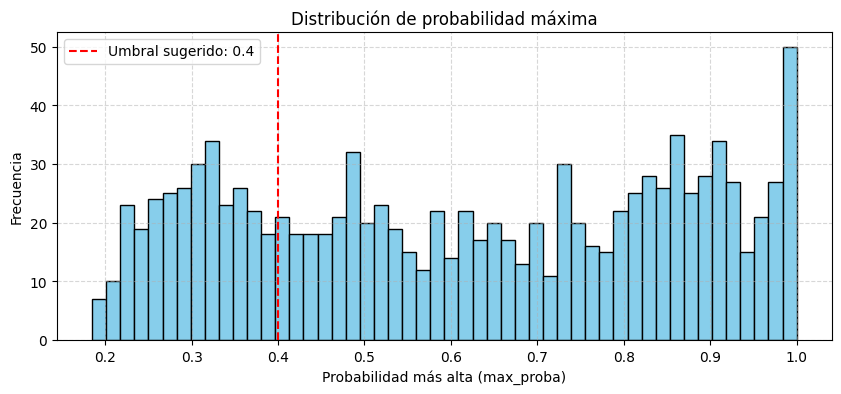

In [85]:
# Gráfico 1: Distribución de la probabilidad máxima
plt.figure(figsize=(10, 4))
plt.hist(features_parallel["max_proba"], bins=50, edgecolor='black', color='skyblue')
plt.axvline(x=0.4, color='red', linestyle='--', label='Umbral sugerido: 0.4')
plt.title("Distribución de probabilidad máxima")
plt.xlabel("Probabilidad más alta (max_proba)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<div class="alert alert-block alert-warning">
  <strong>🔎 Interpretación de la distribución de probabilidad máxima</strong><br><br>
  Este gráfico muestra qué tan seguro está el modelo al predecir cada superpíxel.<br><br>
  Se puede observar que aproximadamente <b>solo 50 superpíxeles</b> tienen una probabilidad cercana a <code>1.0</code>, lo que indica que el modelo está muy seguro al predecir esas clases.<br><br>
  En general, la gráfica parece <b>casi bimodal</b>, ya que hay muchas predicciones tanto con valores <code>&lt; 0.5</code> como con valores <code>&gt; 0.5</code>, lo cual sugiere que la mitad de los casos el modelo está seguro, y en la otra mitad no tanto.
</div>

<div class="alert alert-block alert-info">
  <strong> Distribución de las diferencia de la probabilidad maxima - 2da probabilidad maxima</strong><br>
</div>

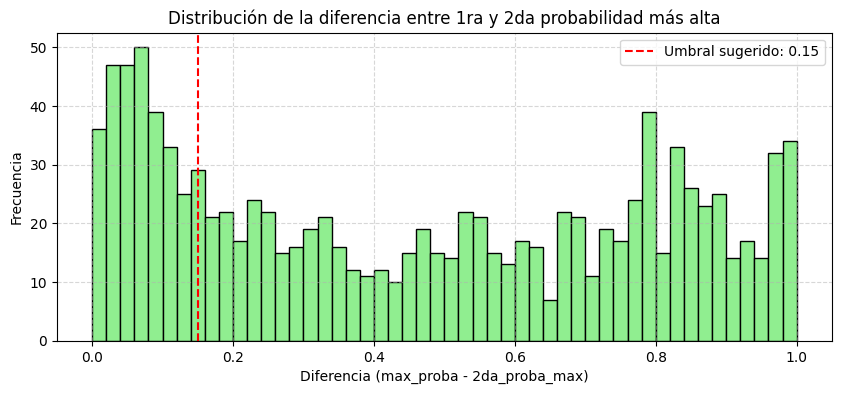

In [83]:
# Gráfico 2: Distribución de la diferencia entre la 1ra y 2da probabilidad
plt.figure(figsize=(10, 4))
plt.hist(features_parallel["dif_proba"], bins=50, edgecolor='black', color='lightgreen')
plt.axvline(x=0.15, color='red', linestyle='--', label='Umbral sugerido: 0.15')
plt.title("Distribución de la diferencia entre 1ra y 2da probabilidad más alta")
plt.xlabel("Diferencia (max_proba - 2da_proba_max)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


<div class="alert alert-block alert-warning">
  <strong>🔍 Interpretación de la diferencia entre la probabilidad máxima y la segunda más alta</strong><br><br>
  Se observa que la gráfica tiene forma de <b>U</b>, es decir, hay una mayor concentración de superpíxeles con diferencias <code>&lt; 0.1</code> y también con diferencias altas, aunque menos frecuente hacia el extremo derecho.<br><br>
  La <b>altura del lado izquierdo</b> de la U es más marcada, lo que indica que el modelo presenta confusión en varios casos (diferencia baja entre las dos categorías más probables).<br><br>
  En términos generales, la distribución parece <b>casi bimodal</b>, con una cantidad similar de superpíxeles en rangos de diferencia <code>&lt; 0.5</code> y <code>&gt; 0.5</code>, aunque con un <b>ligero pico</b> alrededor de <code>0.7</code> que alcanza unas 40 frecuencias.
</div>





<div class="alert alert-block alert-info">
  <strong> Umbral</strong><br>
</div>


<div class="alert alert-block alert-info">
  <strong>📌 Estrategia 1: Basada solo en la diferencia entre la probabilidad más alta y la segunda más alta</strong><br><br>
  De acuerdo al análisis de la <b>distribución de la diferencia de probabilidades</b>, se definió un <b>umbral de 0.02</b>. <br><br>
  Si la diferencia entre la probabilidad más alta y la segunda más alta es <b>menor a 0.02</b>, se considera que el modelo tiene <b>alta incertidumbre</b> entre dos clases y se asigna la categoría <code>10</code> ("Sin etiqueta").<br><br>
  Además, se contabiliza cuántos superpíxeles fueron reasignados con base en esta estrategia.
</div>


In [29]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ESTRATEGIA 1: Basada solo en la diferencia entre la probabilidad más alta y la segunda más alta
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Definir umbral para la diferencia
umbral_dif_simple = 0.02

# Asignar 'Sin etiqueta' (categoría 10) si la diferencia es menor al umbral
features_parallel["prediction_actual_dif"] = np.where(
    features_parallel["dif_proba"] < umbral_dif_simple,
    10,  # Código para "Sin etiqueta"
    features_parallel["prediction"]
)

# Contar cuántos superpíxeles fueron reasignados
num_cambiados_dif = (features_parallel["dif_proba"] < umbral_dif_simple).sum()
print(f" Estrategia 1: Número de superpíxeles que serán cambiados, como Sin etiqueta baja diferencia: {num_cambiados_dif}")


 Estrategia 1: Número de superpíxeles que serán cambiados, como Sin etiqueta baja diferencia: 36



<div class="alert alert-block alert-info">
  <strong>📌 Estrategia 2: Basada en condición conjunta (probabilidad máxima baja o diferencia baja)</strong><br><br>
  Esta estrategia considera que el modelo está inseguro si <b>la probabilidad máxima es baja</b> o si <b>la diferencia entre la probabilidad más alta y la segunda más alta es pequeña</b>.<br><br>
  <ul>
    <li>Se definió un umbral de <code>0.3</code> para la probabilidad máxima.</li>
    <li>Se definió un umbral de <code>0.02</code> para la diferencia entre la primera y segunda probabilidad más alta.</li>
  </ul>
  Si <b>cualquiera</b> de estas condiciones indica incertidumbre, se asigna la categoría <code>10</code> ("Sin etiqueta").<br><br>
  Esta estrategia permite capturar más casos dudosos en los que el modelo podría estar confundido, y es más conservadora que la anterior.
</div>



In [28]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ESTRATEGIA 2: Basada en condición conjunta (probabilidad máxima baja o diferencia baja)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Definir umbrales para ambas condiciones
umbral_max_proba = 0.3
umbral_dif_conjunta = 0.02

# Asignar 'Sin etiqueta' si cualquiera de las dos condiciones indica incertidumbre
features_parallel["prediction_actual_conjunta"] = np.where(
    (features_parallel["max_proba"] < umbral_max_proba) | 
    (features_parallel["dif_proba"] < umbral_dif_conjunta),
    10,  # Código para "Sin etiqueta"
    features_parallel["prediction"]
)

# Contar cuántos superpíxeles fueron reasignados con esta estrategia
num_cambiados_conjunta = (
    (features_parallel["max_proba"] < umbral_max_proba) | 
    (features_parallel["dif_proba"] < umbral_dif_conjunta)
).sum()

print(f" Estrategia 2: Número de superpíxeles que serán cambiados, como Sin etiqueta por condición conjunta: {num_cambiados_conjunta}")


 Estrategia 2: Número de superpíxeles que serán cambiados, como Sin etiqueta por condición conjunta: 147


<div class="alert alert-block alert-info">
  <strong>💾 Guardado del archivo con predicciones por superpíxel</strong><br><br>
  Una vez finalizada la predicción, se guarda un archivo <code>.csv</code> con el nombre <code>Caract_paralelo_[nombre_imagen].csv</code>, que incluye:<br><br>
  <ul>
    <li>Las características extraídas de cada superpíxel.</li>
    <li>La categoría predicha por el modelo (<code>prediction</code>).</li>
    <li>La probabilidad máxima (<code>max_proba</code>) y la segunda más alta (<code>2da_proba_max</code>).</li>
    <li>La diferencia entre ambas (<code>dif_proba</code>) para evaluar la certeza del modelo.</li>
    <li><code>prediction_actual_dif</code>: predicción ajustada asignando "Sin etiqueta" si la diferencia de probabilidad es baja.</li>
    <li><code>prediction_actual_conjunta</code>: predicción ajustada usando una condición más estricta considerando probabilidad máxima baja o diferencia baja.</li>
  </ul><br>
  Este archivo permite documentar y reutilizar los resultados sin necesidad de repetir el proceso de segmentación y predicción. Además, incorpora estrategias de manejo de incertidumbre que ayudan a mejorar la interpretación de los resultados en contextos reales.
</div>


In [31]:
# Guardar el CSV con la predicción
nombre_csv = f"Caract_paralelo_{os.path.splitext(os.path.basename(rut_image))[0]}.csv"
features_parallel.to_csv(nombre_csv, index=False)
print(f" Archivo CSV guardado: {nombre_csv}")

 Archivo CSV guardado: Caract_paralelo_image_x5_331.csv


<div class="alert alert-block alert-info">
  <strong>🎨 Pintado de superpíxeles con las predicciones del modelo</strong><br><br>
  La función <code>img_etiquetas_parallel</code> genera una imagen en la que cada superpíxel es coloreado de acuerdo a su categoría predicha por el modelo.<br><br>
  Además, sobrepone la segmentación de los superpíxeles sobre la imagen original, lo cual facilita la interpretación visual del resultado de la clasificación.<br><br>
  También se calcula el tiempo total que tarda el proceso de <b>pintado</b> y el de <b>cálculo de proporciones</b>, haciendo uso de procesamiento paralelo para mejorar el rendimiento.<br><br>
  En este caso, se utilizó un total de <code>10 hilos</code> (<code>num_threads=10</code>), ya que se determinó como un valor óptimo para el equilibrio entre velocidad y carga de procesamiento.
</div>


<div class="alert alert-block alert-warning">
  <strong>🎯 Pintado usando la estrategia de incertidumbre basada en la diferencia de probabilidad</strong><br><br>
  
  Cuando dicha diferencia es menor a un <b>umbral predefinido = 0.02</b>, se considera que el modelo no tiene certeza suficiente para asignar una única categoría, por lo que se asigna la clase <code>"Sin etiqueta"</code> (código <code>10</code>).<br><br>

  Finalmente, se imprime el número total de superpíxeles que fueron cambiados a la categoría <code>"Sin etiqueta"</code> bajo este criterio.
</div>


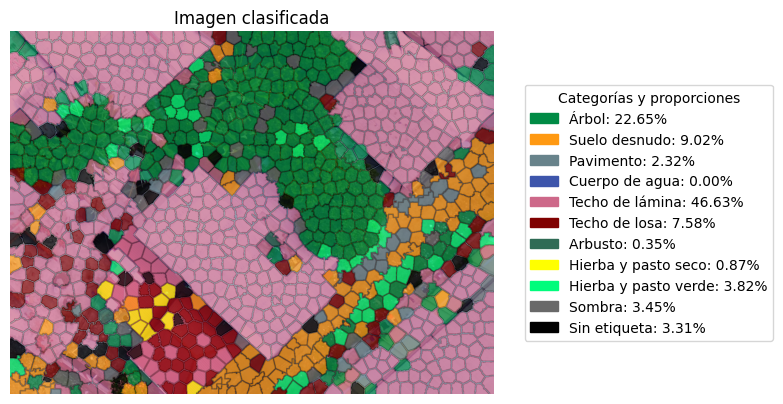

 Estrategia 1: Número de superpíxeles que serán cambiados, como Sin etiqueta baja diferencia: 36


In [32]:
num_hilos_pintado = 10

# Usar predicciones actualizadas al pintar
total_time_pintado_parallel, total_time_proporcion = img_etiquetas_parallel( 
    features_parallel["indice"],                 # Índices de superpíxeles
    features_parallel["prediction_actual_dif"],      # Predicciones del modelo usando la diferencia 
    Labels_slic_parallel,                        # Imagen segmentada por superpíxeles (etiquetas)
    rut_image,                                   # Ruta a la imagen original (RGB)
    img_seg_parallel,                            # Imagen de segmentación para sobreponer
    num_threads=num_hilos_pintado                # Número de hilos (10 en este caso es el optimo)
)
print(f" Estrategia 1: Número de superpíxeles que serán cambiados, como Sin etiqueta baja diferencia: {num_cambiados_dif}")


<div class="alert alert-block alert-warning">
  <strong>🧠 Pintado usando estrategia conjunta de incertidumbre</strong><br><br>
  
  Esta estrategia evalúa dos criterios de incertidumbre en las predicciones del modelo:<br>
  <ul>
    <li><code>max_proba &lt; 0.4</code>: El modelo no está suficientemente seguro de su predicción.</li>
    <li><code>dif_proba &lt; 0.15</code>: La diferencia entre las dos clases más probables es muy pequeña.</li>
  </ul>
  Si alguno de estos criterios se cumple, el superpíxel se clasifica como <code>"Sin etiqueta"</code> (código <code>10</code>), ya que el modelo no tiene la suficiente certeza.<br><br>

  Y finalmente se imprime el número total de superpíxeles que fueron reclasificados como <code>"Sin etiqueta"</code>
</div>


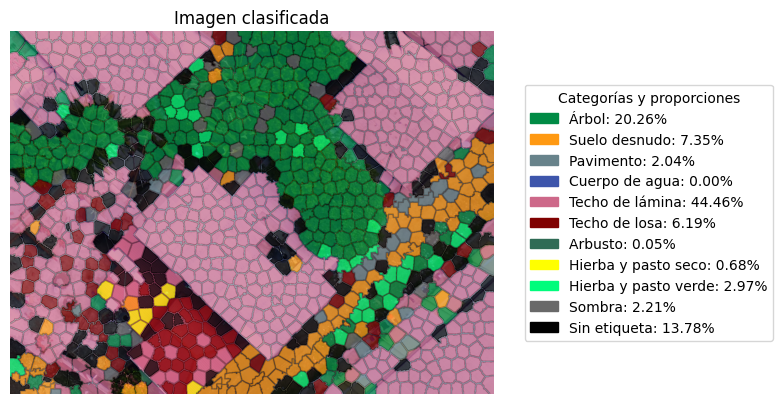

 Número de superpíxeles que serán cambiados, como Sin etiqueta por condición conjunta: 147


In [33]:
num_hilos_pintado = 10

# Usar predicciones actualizadas al pintar
total_time_pintado_parallel, total_time_proporcion = img_etiquetas_parallel( 
    features_parallel["indice"],                 # Índices de superpíxeles
    features_parallel["prediction_actual_conjunta"], # Predicciones del modelo usando la condicion conjunta
    Labels_slic_parallel,                        # Imagen segmentada por superpíxeles (etiquetas)
    rut_image,                                   # Ruta a la imagen original (RGB)
    img_seg_parallel,                            # Imagen de segmentación para sobreponer
    num_threads=num_hilos_pintado                # Número de hilos (10 en este caso es el optimo)
)

print(f" Número de superpíxeles que serán cambiados, como Sin etiqueta por condición conjunta: {num_cambiados_conjunta}")

<div class="alert alert-block alert-info">
  <strong> Tiempos de ejecucion en paralelo:</strong><br>
</div>

In [34]:
print(f"Tiempo de pintado de la imagen segmentada {total_time_pintado_parallel}")
print(f"Tiempo del calculo de las proporciones {total_time_proporcion}")

Tiempo de pintado de la imagen segmentada 3.4216
Tiempo del calculo de las proporciones 4.2921


#
<div class="alert alert-block alert-success">
<b>Extras</b></div>


<div class="alert alert-block alert-info">
  <strong>📊 Cálculo del porcentaje de píxeles por categoría</strong><br><br>
  La función <code>calcular_proporcion_pixeles</code> permite estimar el porcentaje de cobertura de cada categoría en la imagen. Para ello, calcula la proporción de píxeles que pertenecen a superpíxeles clasificados con cada una de las clases.<br><br>

  Esta información es útil para generar resúmenes cuantitativos sobre la composición del paisaje en una imagen, permitiendo identificar qué cobertura es predominante y cómo se distribuyen las categorías en términos de área.<br><br>

  El resultado es un <code>DataFrame</code> que muestra la proporción de píxeles por categoría, expresado como porcentaje del total de la imagen.
</div>



<div class="alert alert-block alert-warning">
  <strong>📊 Porcentaje de píxeles por categoría usando estrategia de la diferencia de probabilidad</strong><br><br>
</div>

Proporciones de superpixel usando la estrategia 1
: {'Árbol': np.float64(22.654102466724538), 'Suelo desnudo': np.float64(9.018000849971065), 'Pavimento': np.float64(2.320918330439815), 'Cuerpo de agua': np.float64(0.0), 'Techo de lámina': np.float64(46.62831624348958), 'Techo de losa': np.float64(7.579662181712964), 'Arbusto': np.float64(0.34987838179976855), 'Hierba y pasto seco': np.float64(0.8670948169849537), 'Hierba y pasto verde': np.float64(3.8249828197337967), 'Sombra': np.float64(3.445378056278935), 'Sin etiqueta': np.float64(3.3116658528645835)}


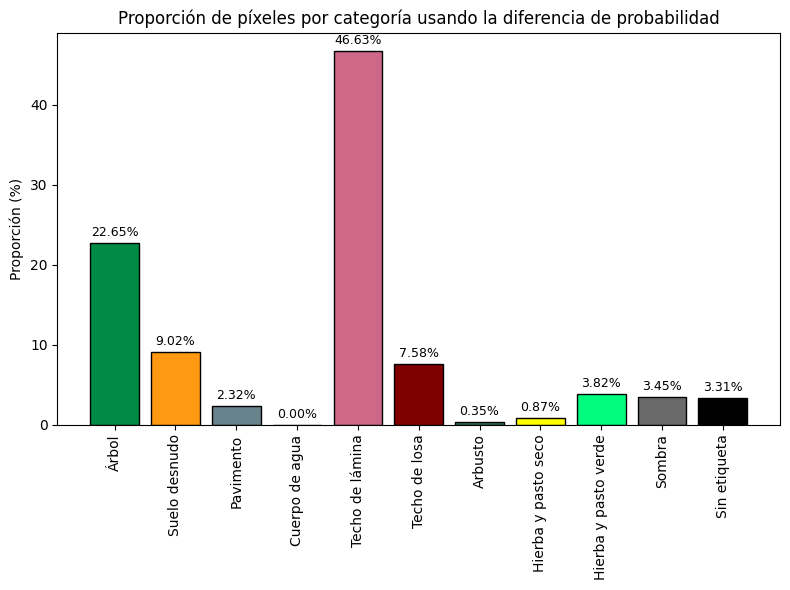

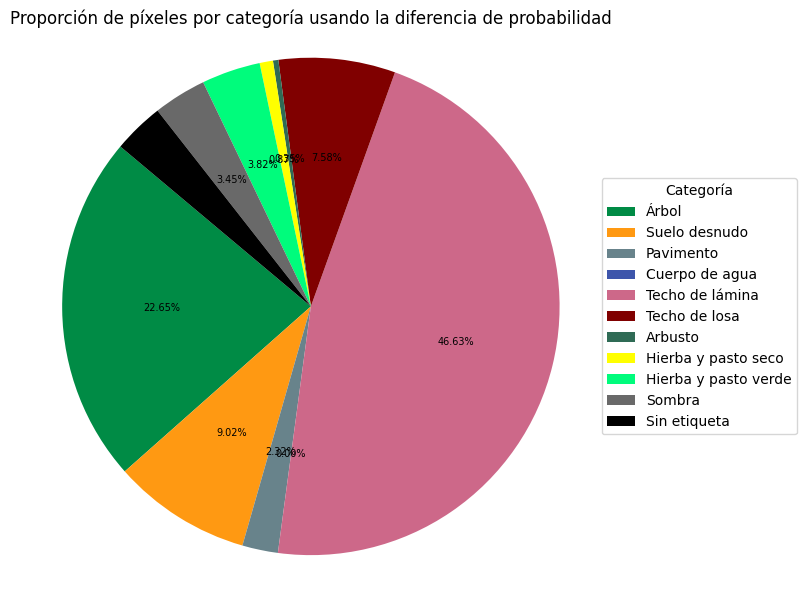

In [77]:
# Diccionario que asocia cada código con su categoría
categorias_dict = {
    0: "Árbol",
    1: "Suelo Desnudo",
    2: "Pavimento",
    3: "Cuerpo de Agua",
    4: "Techo de lámina",
    5: "Techo de losa",
    6: "Arbusto",
    7: "Hierba y pasto seco",
    8: "Hierba y pasto verde",
    9: "Sombra",
    10: "Sin etiqueta"
}

# ---------------------------------------------
# Llamada de la funcion de proporciones usando la primera estrategia
# ---------------------------------------------
proporcion_superpixeles_pred_dif = calcular_proporcion_pixeles(
    features_parallel["indice"].to_numpy(),
    features_parallel["prediction_actual_dif"].to_numpy(),
    Labels_slic_parallel, 
    rut_image,       # la ruta de la imagen original
)
print(f"Proporciones de superpixel usando la estrategia 1:\n {proporcion_superpixeles_pred_dif}")


# Convertir el diccionario a DataFrame para graficar
df_prop = pd.DataFrame(list(proporcion_superpixeles_pred_dif.items()), columns=['Categoria', 'Proporcion'])

color_dict = {
        'Árbol': (0,139,69), 
        'Suelo desnudo': (255, 153, 18), 
        'Pavimento': (104, 131, 139), 
        'Cuerpo de agua': (61, 85, 171), 
        'Techo de lámina': (205, 104, 137), 
        'Techo de losa': (128,0,0),
        'Arbusto': (47, 107, 85),
        'Hierba y pasto seco': (255, 255, 0),
        'Hierba y pasto verde': (0, 252, 124),
        'Sombra': (105, 105, 105),
        'Sin etiqueta': (0,0,0)
}

# Normalizar los valores RGB de 0-255 a 0-1 según el orden de las categorías del DataFrame
colores_rgb_norm = [
    tuple(np.array(color_dict[cat]) / 255.0) for cat in df_prop['Categoria']
]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(df_prop['Categoria'], df_prop['Proporcion'], color=colores_rgb_norm, edgecolor='black')

# Añadir etiquetas de porcentaje encima de cada barra
for bar, porcentaje in zip(bars, df_prop['Proporcion']):
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, altura + 0.5, f'{porcentaje:.2f}%', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=90)
plt.ylabel('Proporción (%)')
plt.title('Proporción de píxeles por categoría usando la diferencia de probabilidad')
plt.tight_layout()
plt.show()


# grafico de pastel:

# Colores normalizados RGB para cada categoría (en el orden de df_prop)
colores_pastel = [
    tuple(np.array(color_dict[cat]) / 255.0) for cat in df_prop['Categoria']
]

# Crear gráfico de pastel
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    df_prop['Proporcion'],
    labels=None,  # Ocultar etiquetas internas
    colors=colores_pastel,
    autopct='%1.2f%%',
    startangle=140
)

# Personalizar los textos de autopct
for autotext in autotexts:
    autotext.set_color('black')        # Letras blancas
    autotext.set_fontsize(7)           # Tamaño más pequeño
    autotext.set_rotation_mode('anchor')  # Rotación natural con la porción

# Leyenda al lado derecho con nombres de categorías
plt.legend(
    wedges,
    df_prop['Categoria'],
    title='Categoría',
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

plt.title('Proporción de píxeles por categoría usando la diferencia de probabilidad')
plt.axis('equal')  # Mantener forma circular
plt.tight_layout()
plt.show()



<div class="alert alert-block alert-warning">
  <strong>📊 Porcentaje de píxeles por categoría usando la estrategia conjunta de incertidumbre</strong><br><br>
</div>

Proporciones de superpixel usando la estrategia 1: 
 {'Árbol': np.float64(20.256664134837962), 'Suelo desnudo': np.float64(7.349310980902778), 'Pavimento': np.float64(2.042925799334491), 'Cuerpo de agua': np.float64(0.0), 'Techo de lámina': np.float64(44.46450692635995), 'Techo de losa': np.float64(6.19365550853588), 'Arbusto': np.float64(0.05374484592013889), 'Hierba y pasto seco': np.float64(0.6785640010127315), 'Hierba y pasto verde': np.float64(2.9704341182002314), 'Sombra': np.float64(2.211902759693287), 'Sin etiqueta': np.float64(13.778290925202546)}


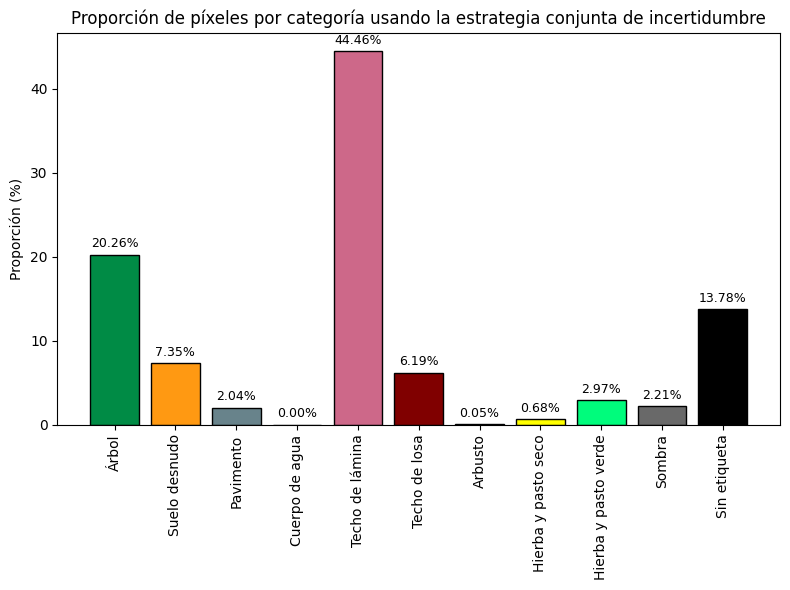

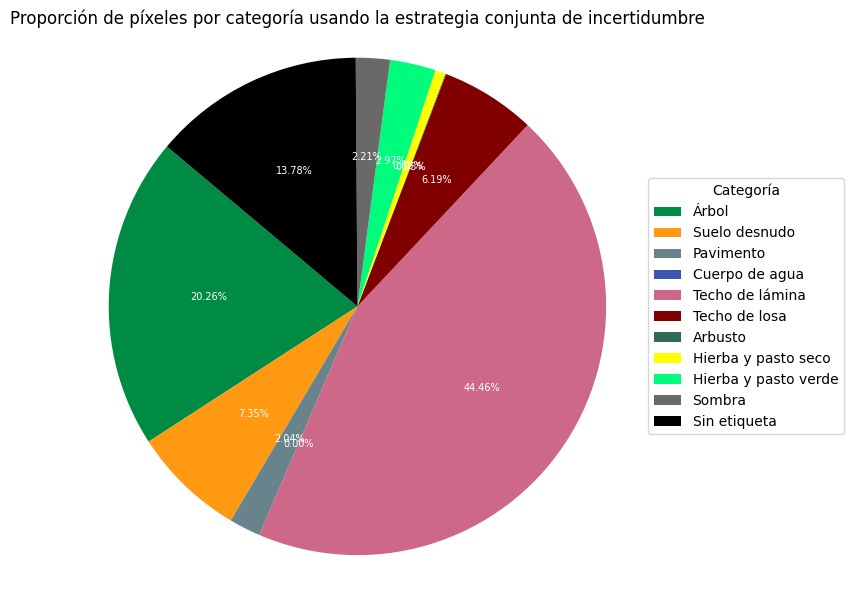

In [80]:
# Diccionario que asocia cada código con su categoría
categorias_dict = {
    0: "Árbol",
    1: "Suelo Desnudo",
    2: "Pavimento",
    3: "Cuerpo de Agua",
    4: "Techo de lámina",
    5: "Techo de losa",
    6: "Arbusto",
    7: "Hierba y pasto seco",
    8: "Hierba y pasto verde",
    9: "Sombra",
    10: "Sin etiqueta"
}

# ---------------------------------------------
# Llamada de la funcion de proporciones usando la segunda estrategia
# ---------------------------------------------
proporcion_superpixeles_pred_conjunta = calcular_proporcion_pixeles(
    features_parallel["indice"].to_numpy(),
    features_parallel["prediction_actual_conjunta"].to_numpy(),
    Labels_slic_parallel, 
    rut_image,
)

print(f"Proporciones de superpixel usando la estrategia 1: \n {proporcion_superpixeles_pred_conjunta}")


# Convertir el diccionario a DataFrame para graficar
df_prop = pd.DataFrame(list(proporcion_superpixeles_pred_conjunta.items()), columns=['Categoria', 'Proporcion'])

# Normalizar los valores RGB de 0-255 a 0-1 según el orden de las categorías del DataFrame
colores_rgb_norm = [
    tuple(np.array(color_dict[cat]) / 255.0) for cat in df_prop['Categoria']
]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(df_prop['Categoria'], df_prop['Proporcion'], color=colores_rgb_norm, edgecolor='black')

# Añadir etiquetas de porcentaje encima de cada barra
for bar, porcentaje in zip(bars, df_prop['Proporcion']):
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, altura + 0.5, f'{porcentaje:.2f}%', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=90)
plt.ylabel('Proporción (%)')
plt.title('Proporción de píxeles por categoría usando la estrategia conjunta de incertidumbre')
plt.tight_layout()
plt.show()


# grafico de pastel:

# Colores normalizados RGB para cada categoría (en el orden de df_prop)
colores_pastel = [
    tuple(np.array(color_dict[cat]) / 255.0) for cat in df_prop['Categoria']
]

# Crear gráfico de pastel
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    df_prop['Proporcion'],
    labels=None,  # Ocultar etiquetas internas
    colors=colores_pastel,
    autopct='%1.2f%%',
    startangle=140
)

# Personalizar los textos de autopct
for autotext in autotexts:
    autotext.set_color('white')        # Letras blancas
    autotext.set_fontsize(7)           # Tamaño más pequeño
    autotext.set_rotation_mode('anchor')  # Rotación natural con la porción

# Leyenda al lado derecho con nombres de categorías
plt.legend(
    wedges,
    df_prop['Categoria'],
    title='Categoría',
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

plt.title('Proporción de píxeles por categoría usando la estrategia conjunta de incertidumbre')
plt.axis('equal')  # Mantener forma circular
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
  <strong>🔍 Visualización de los superpíxeles asignados a una categoría específica</strong><br><br>
  Esta función permite visualizar en la imagen original únicamente los superpíxeles que fueron clasificados con una categoría determinada. Es útil para analizar si el modelo está identificando correctamente ciertas coberturas del paisaje.<br><br>

  En este caso, se está visualizando la categoría <code>'Sin etiqueta'</code>, que corresponde al número <code>10</code> en el vector de predicciones.<br><br>

  <b>Listado de categorías:</b>
  <ul>
    <li><code>0</code>: Árbol</li>
    <li><code>1</code>: Suelo desnudo</li>
    <li><code>2</code>: Pavimento</li>
    <li><code>3</code>: Cuerpo de agua</li>
    <li><code>4</code>: Techo de lámina</li>
    <li><code>5</code>: Techo de losa</li>
    <li><code>6</code>: Arbusto</li>
    <li><code>7</code>: Hierba y pasto seco</li>
    <li><code>8</code>: Hierba y pasto verde</li>
    <li><code>9</code>: Sombra</li>
    <li><code>10</code>: Sin etiqueta</li>
  </ul>

  Puedes cambiar el valor de <code>num_cat</code> para inspeccionar cualquier otra categoría. Los valores válidos van del <code>0</code> al <code>10</code>, y corresponden a las categorías mostradas anteriormente.
</div>


<div class="alert alert-block alert-info">
  <strong>🔍 Visualización de los superpíxeles asignados como Sin etiqueta usando la estrategia 1
</div>

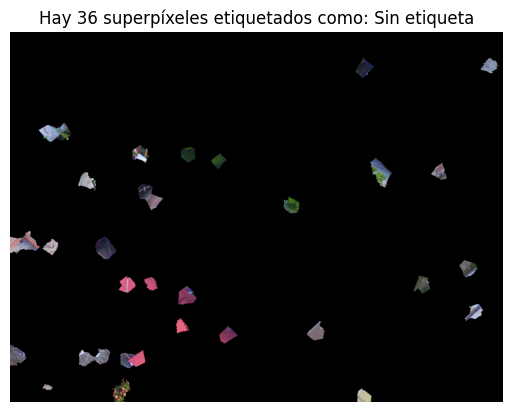

In [82]:
num_cat= 10  # categoria que se quiere inspeccionar [0,10]

ver_superpixeles_categoria(
    features_parallel["indice"].to_numpy(),
    features_parallel["prediction_actual_dif"].to_numpy(),
    Labels_slic_parallel,
    rut_image,                  # ruta de la imagen original
    categoria_objetivo=num_cat  # categoría que se va inspeccionar
)

<div class="alert alert-block alert-info">
  <strong>🔍 Visualización de los superpíxeles asignados como Sin etiqueta usando la estrategia 2
</div>

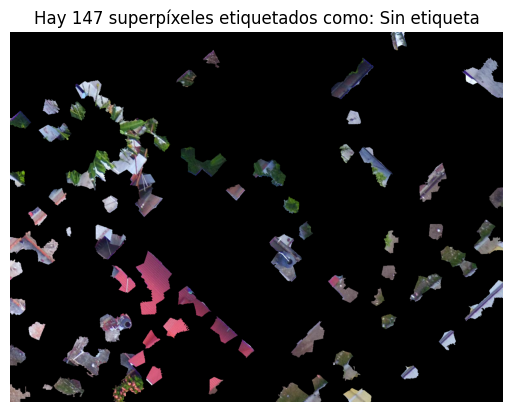

In [84]:
num_cat= 10  # categoria que se quiere inspeccionar [0,10]

ver_superpixeles_categoria(
    features_parallel["indice"].to_numpy(),
    features_parallel["prediction_actual_conjunta"].to_numpy(),
    Labels_slic_parallel,
    rut_image,                  # ruta de la imagen original
    categoria_objetivo=num_cat  # categoría que se va inspeccionar
)